In [1]:
import numpy as np
#import scipy
from scipy import integrate, LowLevelCallable
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import os, ctypes


In [2]:
# def mult_rxn(c,t):
#     cA = c[0]
#     cB = c[1]
#     cC = c[2]
#     cD = c[3]
#     k1 = 1.0
#     k2 = 1.5
#     r1 = k1*cA*cB
#     r2 = k2*cB*cC
#     dAdt = -r1
#     dBdt = -r1-r2
#     dCdt = r1-r2
#     dDdt = r2
#     return [dAdt,dBdt,dCdt,dDdt]

In [3]:
# continue to list a number of variables

In [ ]:
# Kinetic correlations and parameters
# Billimoria 1981, Weng 1975 and Price 1977, the hydrogenation of Benzene example!!
Pram = {'k0' = 3.17e-2,                  # kmol/kgsPa
        'K0' = 3.17e13,                  # 1/Pa
        'E' = 5.76e7,                    # J/kmol
        'Q' = 6.89e7,                    # J/kmol
        'kd0' = 1.80e-4,                 # 1/Pa/s
        'Ed' = 4.53e6,                   # J/kmol
        'R'  = 8.3145,                   # J/mol/K
        'MT' = 4.05e-4,                  # kg/kmol (from Weng, 1.03e-3, mol/kg_catalyst)
        'DeB' = 4.5e-5,                  # m2/s
        'rho_Cp' = 1.46e-6              # J/m3/oC
        'e' = 0.58
       
       }                  


In [ ]:
def lambda_e(LeH,rho_g,Cp_g,U,dp):
    return 5.1*LeH+0.8*rho_g*Cp_g*U*dp

In [ ]:
def cp_g(xH,xB):
    return (2.902*xH + 96.86*xB)*10^4

In [ ]:
def MW_g(xH,xB):
    return 2.106*xH + 78.12*xB

In [ ]:
def rho_g(cB,xB,xH):
    return cB*MW_g(xB,xH)/xB

In [ ]:
def r_B(P,xB,xH,T):
    k0 = 3.17e-2                 
    K0 = 3.17e13                  
    E = 5.76e7                   
    Q = 6.89e7  
    R = 8.3145
    r = (k0*K0*np.exp((Q-E)/(R*T))*P**2*xB*xH)/(1 + K0*np.exp(Q/(R*T))*P*xB)
    return r

def r_T(P,xB,xH,T):
    r = (k0*K0*np.exp((Q-E)/(R*T))*P**2*xB*xH)/(1 + K0*np.exp(Q/(R*T))*P*xB)
    return r

In [4]:
params = {'D':0.01,'U':0.005,'k':0.055,'Le':0.0024,'DeltaH':2.062e10}

In [5]:
def R(c,k):
    r = k*c
    return r

In [6]:
def H(DeltaH,r):
    Q = DeltaH*r
    return Q

In [7]:
def mass_energy_bal(y, t,D,U,k,Le,DeltaH):
    # Define concentrations and Temps according to the output y
    c = y[::2]
    T = y[1::2]
    dx = c[1]-c[0]

    # initialize the output derivatives
    dydt = np.empty_like(y)

    # from the interleaved output derivatives slice out dcdt and dTdt
    # vectors in dydt.
    dcdt = dydt[::2]
    dTdt = dydt[1::2]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + R(c[0], k) + U*0
    dcdt[1:-1] = D * np.diff(c,2) / dx**2 + R(c[1:-1], k) + U
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U*0 + R(c[-1],k)
    
    dTdt[0]    = Le * (-2.0*T[0] + 2.0*T[1]) / dx**2 + H(DeltaH,R(c[0], k)) + U*0 
    dTdt[1:-1] = Le * np.diff(T,2) / dx**2 + U + H(DeltaH,R(c[1:-1], k))
    dTdt[-1]   = Le * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + U*0 + H(DeltaH,R(c[-1],k))
    return dydt

In [8]:
# dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + R(c[0], k) + U*(c[0]-c[0])/(dx) 
# dcdt[1:-1] = D * np.diff(c,2) / dx**2 + R(c[1:-1], k) + U*np.diff(c,1)/(dx) 
# dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U*(c[-2]-c[-2])/(dx) + R(c[-1],k)
    
# dTdt[0]    = Le * (-2.0*T[0] + 2.0*T[1]) / dx**2 + U*(T[0]-T[0])/(dx)+ H(DeltaH,R(c[0], k)) 
# dTdt[1:-1] = Le * np.diff(T,2) / dx**2 + U*np.diff(T)/(dx) + H(DeltaH,R(c[1:-1], k))
# dTdt[-1]   = Le * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + U*(T[-2]-T[-2])/(dx)+ H(DeltaH,R(c[-1],k))


In [9]:
rng = np.random.default_rng()
y0 = np.array([0.5,1,170,180,0.2,160])
#y0 = rng.standard_normal(5000)

t = np.linspace(0, 50, 101)
D = params['D']
U = params['U']
k = params['k']
Le = params['Le']
DeltaH = params['DeltaH']

In [10]:
c = y0[::2]
T = y0[1::2]

In [11]:
T

array([  1., 180.])

In [12]:
solb = odeint(mass_energy_bal, y0, t, args= (D, U, k, Le, DeltaH), ml=2, mu=2)

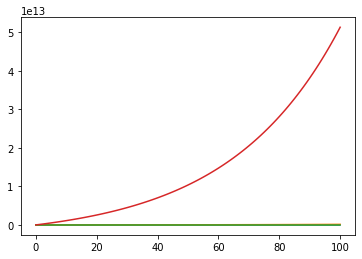

In [14]:
plt.figure()
plt.plot(solb)
plt.show()

In [15]:
def mass_energy_bal2(t,y):
    
    Params = {'D':0.4e-4,'U':0.01,'k':0.055,
              'Le':1.58,'DeltaH':2.062e8}
    
    D = params['D']
    U = params['U']
    k = params['k']
    Le = params['Le']
    DeltaH = params['DeltaH']
       
    c = y[::2]
    T = y[1::2]
    dx = c[1]-c[0]

    # initialize the output derivatives
    dydt = np.empty_like(y)

    # slice out concentrations and Temps derivatives.
    dcdt = dydt[::2]
    dTdt = dydt[1::2]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + R(c[0], k) + U
    dcdt[1:-1] = D * np.diff(c,2) / dx**2 + R(c[1:-1], k) + U
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U + R(c[-1],k)
    
    dTdt[0]    = Le * (-2.0*T[0] + 2.0*T[1]) / dx**2 + H(DeltaH,R(c[0], k)) + U 
    dTdt[1:-1] = Le * np.diff(T,2) / dx**2 + U + H(DeltaH,R(c[1:-1], k))
    dTdt[-1]   = Le * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + U + H(DeltaH,R(c[-1],k))

    return dydt

In [16]:
solc = solve_ivp(mass_energy_bal2,t,y0, method='RK45')


In [17]:
solc.t.shape

(11,)

In [18]:
solc.y[0].shape

(11,)

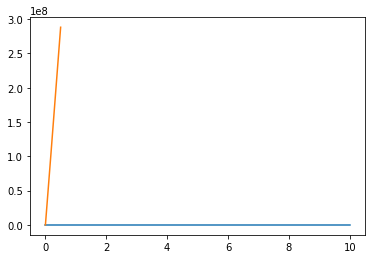

In [19]:
plt.figure()
plt.plot(solc.t)
plt.plot(solc.t,solc.y[1])
# plt.plot(solc.y[1])
plt.show()

In [20]:
# np.diff command
b1 = np.array([1, 3, 4, 7, 9])
print("First order difference  : ", np.diff(b1))
print("Second order difference : ", np.diff(b1, n = 2))
print("Third order difference  : ", np.diff(b1, n = 3))

First order difference  :  [2 1 3 2]
Second order difference :  [-1  2 -1]
Third order difference  :  [ 3 -3]


In [21]:
# def f(y,t):
#     dydt = y*np.exp(-t)
#     return dydt
# t = np.linspace(0,10) # linspace(start,stop,num =?)
# y0 = 0.2
# y = odeint(f,y0,t)

# plt.figure(figsize = (6,4))
# plt.plot(t,y)
# plt.xlabel('Time (sec)')
# plt.ylabel('y(t)')
# plt.show()


In [22]:
#rng = np.random.default_rng(12345)

In [23]:
# Example for empty arrays
a = np.array([1,3,5])
b = np.array([2,4,6])

c = np.empty((a.size + b.size,), dtype=a.dtype)
c[0::2] = a
c[1::2] = b

In [24]:
y0

array([  0.5,   1. , 170. , 180. ])

In [25]:
#%timeit sola = odeint(grayscott1d, y0, t, args=(f, k, Du, Dv, dx))
#%timeit sola = odeint(grayscott1d, y0, t, args=(f, k, Du, Dv, dx))

In [26]:
#Now set ml=2 and mu=2, so odeint knows that the Jacobian matrix is banded:

In [27]:
# %timeit solb = odeint(grayscott1d, y0, t, args=(f, k, Du, Dv, dx), ml=2, mu=2)
# solb = odeint(grayscott1d, y0, t, args=(f, k, Du, Dv, dx), ml=2, mu=2)


In [28]:
#That is quite a bit faster!
#Let’s ensure that they have computed the same result:

In [29]:
# ode_fn = lambda t, x: np.sin(t) + 3. * np.cos(2. * t) - x

# an_sol = lambda t : (1./2.) * np.sin(t) - (1./2.) * np.cos(t) + \
#                     (3./5.) * np.cos(2.*t) + (6./5.) * np.sin(2.*t) - \
#                     (1./10.) * np.exp(-t)
# t_begin=0.
# t_end=10.
# t_nsamples=100
# t_space = np.linspace(t_begin, t_end, t_nsamples)
# x_init = 0.

# x_an_sol = an_sol(t_space)

# method = 'RK45' #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
# num_sol = solve_ivp(ode_fn, [t_begin, t_end], [x_init], method=method, dense_output=True)
# x_num_sol = num_sol.sol(t_space).T

# plt.figure()
# plt.plot(t_space, x_an_sol, '--', linewidth=2, label='analytical')
# plt.plot(t_space, x_num_sol, linewidth=1, label='numerical')
# plt.title('ODE 1st order IVP solved by SciPy with method=' + method)
# plt.xlabel('t')
# plt.ylabel('x')
# plt.legend()
# plt.show()

In [30]:
# # Reaction  A+B = C and B+C = D

# def mult_rxn(c,t):
#     cA = c[0]
#     cB = c[1]
#     cC = c[2]
#     cD = c[3]
#     k1 = 1.0
#     k2 = 1.5
#     r1 = k1*cA*cB
#     r2 = k2*cB*cC
#     dAdt = -r1
#     dBdt = -r1-r2
#     dCdt = r1-r2
#     dDdt = r2
#     return [dAdt,dBdt,dCdt,dDdt]

# # for the solver
# c0 = [1,1,0,0] # initial A and B = 1; C and D = 0
# t = np.arange(0,3.01,0.2)
# c = odeint(mult_rxn,c0,t)

# cA = c[:,0]
# cB = c[:,1]
# cC = c[:,2]
# cD = c[:,3]

# # selectivity
# S = np.empty(len(cC))
# for i in range(len(cC)):
#     if abs(cC[i]+cD[i] > 1e-10):
#         S[i] = cC[i]/(cC[i]+cD[i])
#     else:
#         S[i] = 1.0
        
# plt.figure(figsize = (6,4))
# plt.plot(t,cA,label = 'cA')
# plt.plot(t,cB,label ='cB')
# plt.plot(t,cC,label = 'cC')
# plt.plot(t,cD,label ='cD')
# plt.plot(t,S,label ='Sel')
# plt.xlabel('Time (sec)')
# plt.ylabel('concentration')
# plt.legend()
# plt.savefig('mult_rxns.png')
# plt.show()

In [31]:
# solving the Heat Equation
# given details

In [32]:
# l = 0.1 # wall thickness
# n = 10 # num of slices
# T0 = 0 # initial wall temps
# T1s = 40 # wall surface temp. at the beginning
# T2s = 20 # wall surface temp. at the end
# dx = l/n
# alpha = 0.0001 # thermal diffisivity
# t_final = 60
# dt = 0.1

# # points to plot or visualize
# x = np.linspace(dx/2,l-dx/2,n)
# # Temp. measurements along x of the wall 
# T = np.ones(n)*T0 # 
# # derivative vector, to be over written
# dTdt = np.empty(n)
# # time vector
# t = np.arange(0,t_final,dt)

# #through time, t and space, x
# #plt.clf() didn't work
# for j in range(1,len(t)):    
#     for i in range(1,n-1):
#         dTdt[i] = alpha*(-(T[i]-T[i-1])/dx**2+(T[i+1]-T[i])/dx**2)
#     dTdt[0] = alpha*(-(T[0]-T1s)/dx**2+(T[1]-T[0])/dx**2)
#     dTdt[n-1] = alpha*(-(T[n-1]-T[n-2])/dx**2+(T2s-T[n-1])/dx**2)
#     T = T + dTdt*dt
# plt.figure()
# plt.plot(x,T)
# plt.axis([0, l,0, 50])
# plt.xlabel('Distance x, (m)')
# plt.ylabel('Temp., (C)')
# plt.show()
# plt.pause(0.01)

In [33]:
# Solve the heat equation using the odeint solver

In [34]:
# def heat_eqn(T,t):
#     l = 0.1
#     n = 10
#     T0 = 0
#     T1s = 40
#     T2s = 20
#     dx = l/n
#     dt = 0.1
#     alpha = 0.0001
#     t_final = 60
#     t = np.arange(0,t_final,dt)
#     T = np.ones(n)*T0
#     dTdt = np.empty(n)
    
#     for j in range(1,len(t)):
#         for i in range(1,n-1):
#             dTdt[i] = alpha*(-(T[i]-T[i-1])/dx**2+(T[i+1]-T[i])/dx**2)
#     dTdt[0] = alpha*(-(T[0]-T1s)/dx**2+(T[1]-T[0])/dx**2)
#     dTdt[n-1] = alpha*(-(T[n-1]-T[n-2])/dx**2+(T2s-T[n-1])/dx**2)
#     return dTdt

# # solve for temp. using the solver, odeint
# l = 0.1
# n = 10
# T0 = 0
# dx = l/n
# T_0 = np.ones(n)*T0 # 
# t_final = 60
# x = np.linspace(dx/2,l-dx/2,n)

# dt = 0.1
# x = np.linspace(dx/2,l-dx/2,n)
# t = np.arange(0,t_final,dt)
# T = np.ones(n)*T0
# T = T + heat_eqn*dt
# #T = odeint(heat_eqn,T_0,t) # did not work?!

# plt.figure(figsize = (6,4))
# plt.plot(x,T)
# plt.axis([0, l,0, 50])
# plt.xlabel('Distance (m)')
# plt.ylabel('Temp.(C)')
# plt.show()